# Making colour images from data layers

This notebook shows how to make digital colour images by combining data layers, using two techniques:<br>
1) set 3 layers as the RGB channels;<br>
2) colourize any number of layers and blend them.<br>
Both techniques are commonly used for scientific visualization, in particular to create images from astronomical data.<br>

Note that we do not consider here:<br>
\- the preliminary steps of data registration and data stretching; <br>
\- the final steps of making global adjustments, cosmetic edits, and cropping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# custom plt.imshow()
def plt_show(array,ax=None,cmap='gray',vmin=None,vmax=None,title="",fname=""):
    if ax==None: ax=plt.gca()
    ax.imshow(array,origin='lower',aspect='equal',cmap=cmap,vmin=vmin,vmax=vmax)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    if title!="": ax.set_title(title)
    if fname!="": plt.imsave(arr=np.clip(array,0,1),fname=fname+".png",origin='lower',cmap=cmap)

In [3]:
# custom plt.subplots()
def show_layers(layers, size=3, fname=""):
    fig, ax = plt.subplots(1,len(layers), figsize=(len(layers)*size,size))
    if len(layers)==1: 
        plt_show(layers[0],ax=ax,fname=fname)
    else:
        for i in range(len(layers)): 
            fname_i = "%s_%i"%(fname,i) if fname != "" else ""
            plt_show(layers[i],ax=ax[i],fname=fname_i)

## mock data

To keep this tutorial simple and generic, we use mock 2D data, fabricated by splatting random Gaussian clumps. The relevant functions are found in [```mock.py```](https://github.com/gillesferrand/colour-composite/blob/master/mock.py), knowing their inner working is not necessary. We are aiming for some amount of spatial colocation, and having a range of intensities. (To use your own data, simply load them into a numpy array). 

In [4]:
import mock

In [5]:
nx = 256
ny = 256

np.random.seed(42) # for reproducibility

layers = []
data_diff = mock.Gaussian_clumps(nx=nx, ny=ny, n_clumps=1, sigma=[0.50], amp=[0.1], x=[0.5], y=[0.5], delta=0.2)
for j in range(6):
    data = mock.Gaussian_clumps(nx=nx, ny=ny, n_clumps=10, sigma=[0.15], amp=[0.1], x=[0.5], y=[0.5], delta=0.3)
    data += data_diff
    data -= data.min()
    data /= data.max()
    layers.append(data)
    print("layer %i : %.4f – %.4f, %.4f"%(j,data.min(),data.max(),data.mean()))

layer 0 : 0.0000 – 1.0000, 0.3278
layer 1 : 0.0000 – 1.0000, 0.3476
layer 2 : 0.0000 – 1.0000, 0.3661
layer 3 : 0.0000 – 1.0000, 0.2529
layer 4 : 0.0000 – 1.0000, 0.3113
layer 5 : 0.0000 – 1.0000, 0.1733


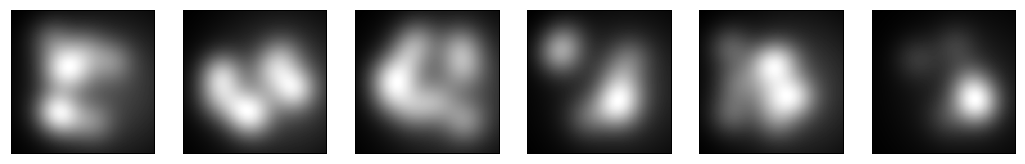

In [6]:
show_layers(layers, fname="layer")

The data are displayed here by mapping their (normalized) values to a grey scale. We could also, for any single data layer, display it with any colour mapping we like. What we are after in this tutorial, is combining several of these data layers into a single colour image. The relevant functions are found in [```combine.py```](https://github.com/gillesferrand/colour-composite/blob/master/combine.py), and will be presented in more detail below.

In [7]:
import combine

## The basic way: RGB channels

Computer colour images are made from 3 *channels*: red (R), green (G), blue (B). This provides a way of making a colour image from data layers: use one data layer per each channel. Note that the data have to be properly normalized (in Matplotlib, channel values range in [0,1]). This technique is straightforward, but works with exactly 3 layers (to use more, one needs to somehow merge the data first). 
It is illustrated in the sketch below, that shows histograms along a 1D slice.

![sketch RGB](sketch_RGB.png)

Combining layers as R,G,B channels is implemented by ```combine.RGB(layers)``` that takes a list of 3 layers (each layer is a M×N 2D array) and returns an image (a M×N×3 3D array).

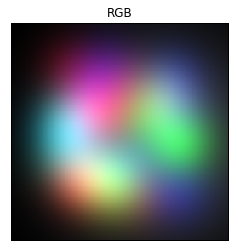

In [8]:
# using the first 3 layers
image = combine.RGB(layers[0:3])
plt_show(image, title="RGB", fname="image - RGB")

Where layers overlap, new colours are produced, following the RGB additive model: R + G = yellow (Y), G + B = cyan (C), B + R = magenta (M). Where no data is present, the colour is black. Where data accumulates, the colour lightens towards white.

With this technique, hue choices are restricted to the 3 RGB primaries. To get different colours, one could to do further manipulations on the image, as in the examples below. (You may want to come back to these, after learning how to blend C,M,Y layers in the next section).

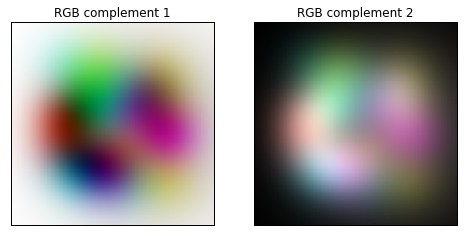

In [9]:
# image complement (two ways)

# 1/ take the complement value, channel by channel
image_cmp1 = np.zeros(image.shape)
for i in range(3): image_cmp1[:,:,i] = 1-image[:,:,i]

# 2/ take the complement over the channels
image_cmp2 = np.zeros(image.shape)
other = {0: [1, 2], 1: [0, 2], 2: [0, 1]}
for i in range(3): image_cmp2[:,:,i] += 0.5*(image[:,:,other[i][0]]+image[:,:,other[i][1]])

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_cmp1, ax[0], title="RGB complement 1", fname="image - RGB complement 1")
plt_show(image_cmp2, ax[1], title="RGB complement 2", fname="image - RGB complement 2")

In the first version, reversing each channel (X' = 1-X) swaps each hue with its complement (B → Y, R → C, G → M), and also reverses black and white. In the second version, transfering each channel into the others (X' = Y/2 + Z/2) also swaps the hues, but keeps black and white.

## The advanced way: blending layers

This technique works with any number of layers, and allows one to select any colour per layer. It takes two steps: colourize each layer, then blend all the layers. See the [paper by Rector et al (2007)](https://ui.adsabs.harvard.edu/abs/2007AJ....133..598R/abstract) and the [workshop by Prof. Jayanne English (2009)](http://www2.physics.umanitoba.ca/u/english/viz2009/) for a step by step implementation using an image manipulation package like Photoshop or GIMP, in the context of astronomy. Here we demonstrate the algorithm in code using Python.

**Colourizing** a data layer can be done by assigning it to one or more of the 3 R,G,B channels that make a colour image, with free weights for the three channels (equal weights result in grey).<br> 
Colourization is implemented by ```combine.colourize_RGB(layer, R, G, B)``` that takes a data layer (a 2D array) and a triplet of R,G,B weights, and returns an image (a 3D array). The convenience function ```combine.colourize_RGB_list(layers, R, G, B)``` processes a list of layers and corresponding R,G,B weights, and returns a list of colourized layers.

As a first example let us use the R,G,B primary colours.

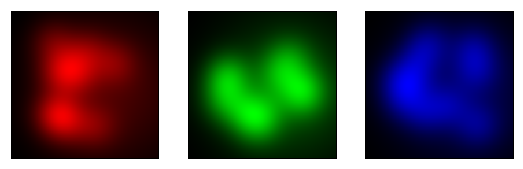

In [10]:
# using the first 3 layers, with the same 3 primaries R,G,B
R = [1, 0, 0]
G = [0, 1, 0]
B = [0, 0, 1]
colourized_layers = combine.colourize_RGB_list(layers[0:3], R, G, B)

show_layers(colourized_layers)

Note that the colourization could be done using other colour models, then converting the result to RGB. For example, one may prefer to work in a perceptual model, in terms of hue (H), saturation (S) or chroma (C), and lightness (L) value (V). The function ```colourize_HSV(layer, H, S, V)``` demonstrates this using the cylindrical HSV model. The code below produces the same colourization as the code above. (The HSV colour model is easy to use, although it fails to represent human perception. Perceptually correct colour models are the models made by CIE: XYZ, Lab, Lch, and more. In this tutorial we stay at the computer level, so in RGBland.)

In [11]:
# using the first 3 layers, with the same 3 primaries R,G,B
H = [0, 120, 240] # hues as degrees on the colour wheel
S = [100]         # % of saturation
V = [100]         # % of lightness
colourized_layers = combine.colourize_HSV_list(layers[0:3], H, S, V)

**Blending** colourized layers requires defining a *blending mode* (or *mixing mode*), that is a way to calculate, for each pixel, the colour in the resulting image based on the colours in the layers to be blended. In practice, this is commonly done by applying a function channel by channel. Many blending modes have been defined, several are implemented at the end of ```combine.py```. Two popular choices are *add* (also known as *linear dodge*) and *screen*, defined by<br>
```add(A,B) = A + B```<br>
```screen(A,B) = 1 - (1-A)×(1-B)```<br>
where ```A``` is the active layer (the new layer to blend), ```B``` is the background layer (the image made so far), and the operation is done channel by channel (that is separately for ```X = R, G, B```).<br>

The *screen* mode has the following properties:<br>
```screen(A,B) = A+B - A×B``` : can be thought of as a dampened *add*<br>
```screen(A,B) = screen(B,A)``` : symmetric<br>
```screen(A,B) > max(A,B)``` : always lighter than the original<br>
```screen(A,0) = A``` : screening with black makes no change<br>
```screen(A,1) = 1``` : screening with white produces white<br>
According to the [Photoshop documentation](https://helpx.adobe.com/photoshop/using/blending-modes.html), "the effect is similar to projecting multiple photographic slides on top of each other".<br>

Blending colour images is implemented in the function ```combine.blend(layers, mode)``` that takes a list of previously colourized layers (one layer is now a 3D array) and a blending mode (a function of two layers), and returns a new colour image (a 3D array).

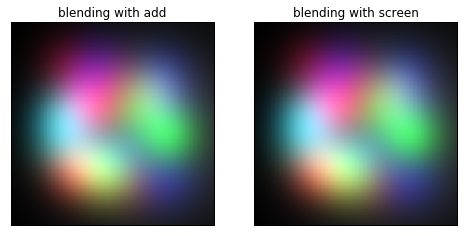

In [12]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add, ax[0], title="blending with add"   , fname="image - blend add - 3 primaries")
plt_show(image_scr, ax[1], title="blending with screen", fname="image - blend screen - 3 primaries")

With either *add* or *screen* mode, blending 3 layers, where each layer has been colourized with one of the R,G,B primaries, results in the same image as the one produced previously by assigning each layer to the R,G,B channels, as illustrated in the sketch below. 

![sketch RGB](sketch_blend_RGB.png)

The point of the exercise is that we are no longer limited to the R,G,B primaries. As a second example, let us use the C,M,Y secondary coulours.

![sketch RGB](sketch_blend_CMY.png)

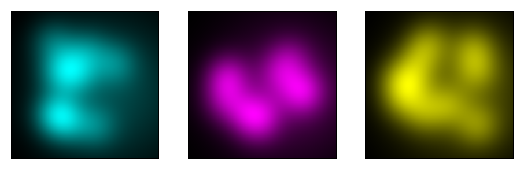

In [13]:
# using the first 3 layers, with the 3 secondaries C,M,Y
R = [0, 1, 1]
G = [1, 0, 1]
B = [1, 1, 0]
colourized_layers = combine.colourize_RGB_list(layers[0:3], R, G, B)

show_layers(colourized_layers)

Note that *add* can quickly saturate (the result overshoots the max possible, resulting in clipping), whereas *screen* never does. When using *add* one may want to adjust the intensity levels per layer appropriately, before blending them; alternatively one may adjust the intensity levels on the blended image, although this will produce a different result in general. By default ```blend(norm=True)``` ensures that each channel stays in the allowed range [0,1] after blending all the layers.

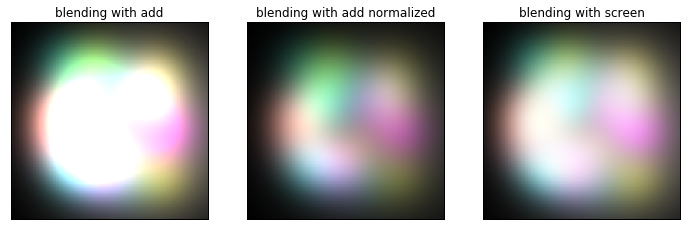

In [14]:
image_addF = combine.blend(colourized_layers, combine.Add, norm=False)
image_addT = combine.blend(colourized_layers, combine.Add, norm=True)
image_scr  = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plt_show(image_addF, ax[0], title="blending with add"           , fname="image - blend add - 3 secondaries")
plt_show(image_addT, ax[1], title="blending with add normalized", fname="image - blend add norm - 3 secondaries")
plt_show(image_scr , ax[2], title="blending with screen"        , fname="image - blend screen - 3 secondaries")

Compared with the previous case:<br>
\- Colours are lighter. Since each colourized layer has now two non-zero channels, blending them produces white more quickly.<br>
\- Hues are inverted (in the same way as the second version of the complement of the RGB composite made earlier: the background stays black).<br>

A third example, with 3 arbitrary colours:

![sketch RGB](sketch_blend_any.png)

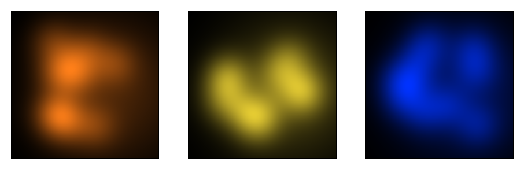

In [15]:
# using the first 3 layers, with 3 arbitrary colours
R = [1.0, 0.9, 0.0]
G = [0.5, 0.8, 0.2]
B = [0.1, 0.2, 1.0]
colourized_layers = combine.colourize_RGB_list(layers[0:3], R, G, B)

show_layers(colourized_layers)

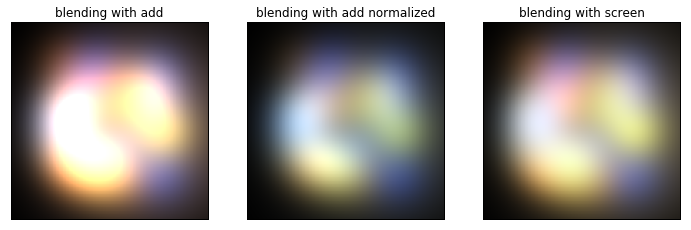

In [16]:
image_addF = combine.blend(colourized_layers, combine.Add, norm=False)
image_addT = combine.blend(colourized_layers, combine.Add, norm=True)
image_scr  = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plt_show(image_addF, ax[0], title="blending with add"           , fname="image - blend add - 3")
plt_show(image_addT, ax[1], title="blending with add normalized", fname="image - blend add norm - 3")
plt_show(image_scr , ax[2], title="blending with screen"        , fname="image - blend screen - 3")

The *add* and *screen* modes produce different results. With no tuning, *screen* seems to capture the best of what *add* can do; it more clearly retains the intensity distribution in the data.

One can also use more than 3 layers – with the caveat that the colour mixing becomes more complex, and tends towards white more quickly. As a final example, let us use the 6 data layers with 6 different colours.

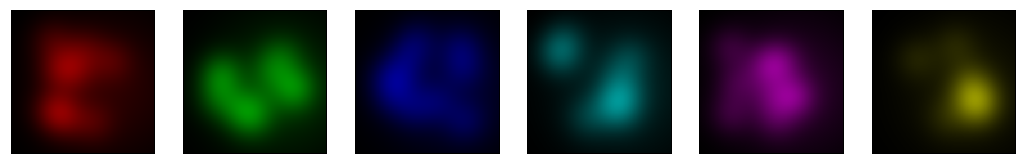

In [17]:
# using the 6 layers, with 6 colours = the 3 primaries + the 3 secondaries
w = 0.6
R = [w, 0, 0, 0, w, w]
G = [0, w, 0, w, 0, w]
B = [0, 0, w, w, w, 0]
colourized_layers = combine.colourize_RGB_list(layers[0:6], R, G, B)

show_layers(colourized_layers)

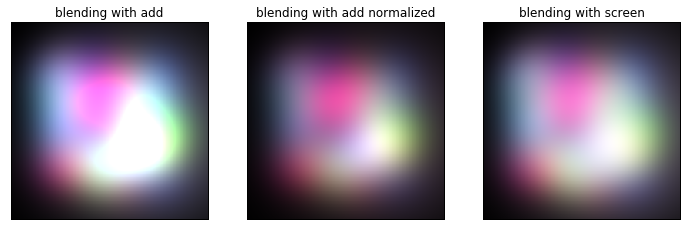

In [18]:
image_addF = combine.blend(colourized_layers, combine.Add, norm=False)
image_addT = combine.blend(colourized_layers, combine.Add, norm=True)
image_scr  = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plt_show(image_addF, ax[0], title="blending with add"           , fname="image - blend add - 6")
plt_show(image_addT, ax[1], title="blending with add normalized", fname="image - blend add norm - 6")
plt_show(image_scr , ax[2], title="blending with screen"        , fname="image - blend screen - 6")

Blending colourized layers is a technique rich in possibilities – time for you to experiment.

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>
<br>Gilles Ferrand
<br>2021-06-05